In [4]:
%%capture
!pip install torchinfo
!pip install torchmetrics



In [5]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Opencv
import cv2

# Preprocessing
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn,optim
from torchinfo import summary
from torchmetrics.classification import BinaryAccuracy
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b2

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score

# os
import os

# tqdm
from tqdm.auto import tqdm

# Path
from pathlib import Path

# random
import random

# Typing
from typing import Dict,List

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:


images_path = Path("/content/BrainScans")

# List all image files within subdirectories
images_path_list = list(images_path.glob("*/*.jpg"))

# Continue with the rest of your code


images_path = "/content/BrainScans"
total_classes = os.listdir(images_path)

# Filter out the '.ipynb_checkpoints' directory
total_classes = [c for c in total_classes if c != '.ipynb_checkpoints']

print(f"Total classes = {total_classes}")


Total classes = ['negitave', 'positive']


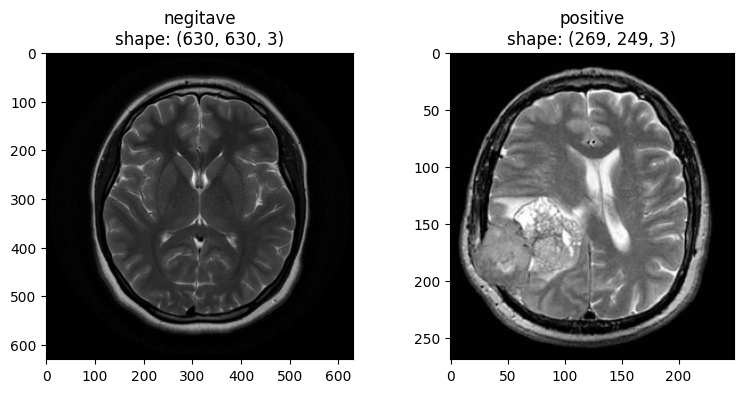

In [15]:
# Let's display 1 image for each class.



fig, ax = plt.subplots(1, len(total_classes), figsize=(8, 4))

for i, c in enumerate(total_classes):
    img_path_class = Path(images_path) / c
    img_path_list = list(img_path_class.glob("*.jpg"))

    if img_path_list:
        img_selected = random.choice(img_path_list)
        img_BGR = cv2.imread(str(img_selected))
        img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
        ax[i].imshow(img_RGB)
        ax[i].set_title(f"{img_selected.parent.stem}\nshape: {img_RGB.shape}")
    else:
        ax[i].set_title(f"No images for {c}")

plt.tight_layout()
plt.show()

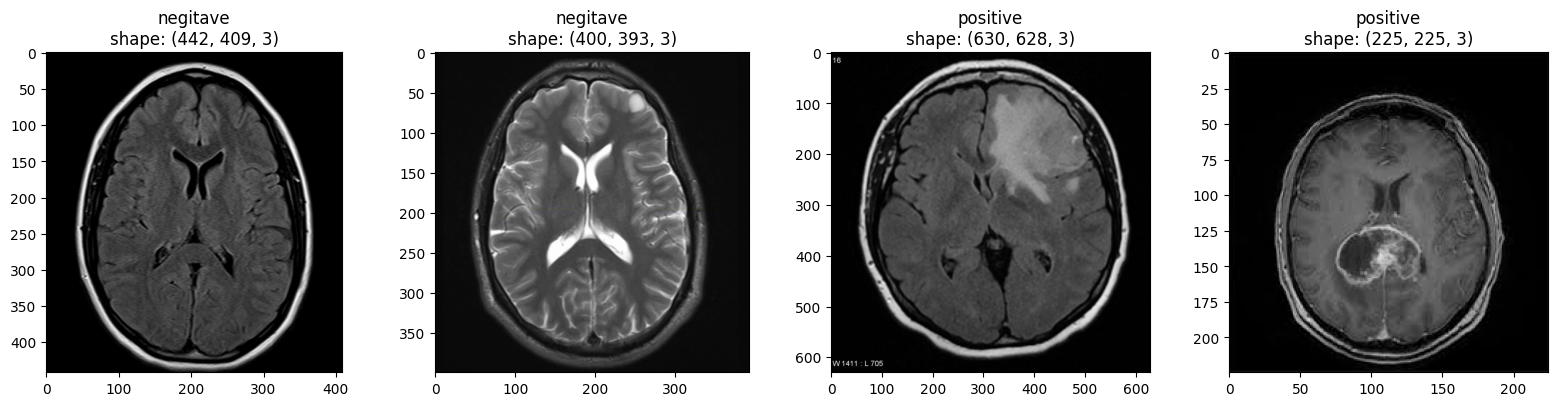

In [10]:
num_images_per_class = 2  # Adjust the number of images per class as needed
fig, ax = plt.subplots(1, len(total_classes) * num_images_per_class, figsize=(16, 4))

for i, c in enumerate(total_classes):
    img_path_class = Path(images_path) / c
    img_path_list = list(img_path_class.glob("*.jpg"))

    for j in range(num_images_per_class):
        if j < len(img_path_list):
            img_selected = random.choice(img_path_list)
            img_BGR = cv2.imread(str(img_selected))
            img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
            ax[i * num_images_per_class + j].imshow(img_RGB)
            ax[i * num_images_per_class + j].set_title(f"{img_selected.parent.stem}\nshape: {img_RGB.shape}")
        else:
            ax[i * num_images_per_class + j].set_title(f"No images for {c}")

plt.tight_layout()
plt.show()


In [14]:
# Number of images per class.
total_images_negative = len(os.listdir("/content/BrainScans/negitave"))
total_images_positive = len(os.listdir("/content/BrainScans/positive"))

print(f'negative = {total_images_negative} images')
print(f'positive = {total_images_positive} images')

negative = 98 images
positive = 129 images


In [16]:
image_path_and_class = {"image_path":[],
                      "target":[]}

for img_path in images_path_list:
    image_path_and_class["image_path"].append(img_path)
    image_path_and_class["target"].append(img_path.parent.stem)

df_image_path_and_class = pd.DataFrame(image_path_and_class)
df_image_path_and_class.head()

,image_path,target
0,/content/BrainScans/negitave/76.jpg,negitave
1,/content/BrainScans/negitave/56.jpg,negitave
2,/content/BrainScans/negitave/64.jpg,negitave
3,/content/BrainScans/negitave/47.jpg,negitave
4,/content/BrainScans/negitave/42.jpg,negitave


In [17]:
# We separate the paths of the images and their corresponding label.
X = df_image_path_and_class.drop("target", axis = 1)
y = df_image_path_and_class["target"]


In [18]:
SEED = 123
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, random_state = SEED, stratify = y)

In [19]:
# We apply a mapping to our target variable to binarize.
# 0: negative
# 1:positive

label_map = {'positive':1,
             'negative':0}

y_train_array = np.array(y_train.map(label_map), dtype = float).reshape(-1,1)
y_train_torch = torch.from_numpy(y_train_array)

y_test_array = np.array(y_test.map(label_map), dtype = float).reshape(-1,1)
y_test_torch = torch.from_numpy(y_test_array)

In [20]:
# Transformations that we apply to the training and test set.
train_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

test_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()])

In [21]:
# We apply the transformations to our images through an iteration to our data sets.

# Transformations to the training set.
total_images_train = len(X_train)
images_train = [None]*total_images_train

for i,(_,img_path_train) in enumerate(X_train.iterrows()):
    img_train = Image.open(Path(img_path_train[0])).convert("RGB")
    images_train[i] = train_transforms(img_train)


# Transformations to the test set.
total_images_test = len(X_test)
images_test = [None]*total_images_test

for i,(_,img_path_test) in enumerate(X_test.iterrows()):
    img_test = Image.open(Path(img_path_test[0])).convert("RGB")
    images_test[i] = test_transforms(img_test)

In [22]:
# We stack all our images.
X_train_torch = torch.stack(images_train)
X_test_torch = torch.stack(images_test)

In [23]:
# We create a Dataset class to create our Datasets.
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        x = self.data[idx]
        y = self.target[idx]

        return x,y

In [24]:
train_dataset = CustomDataset(X_train_torch, y_train_torch)
test_dataset = CustomDataset(X_test_torch, y_test_torch)

In [25]:
BATCH_SIZE = 7
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)

test_dataloader = DataLoader(test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False,
                             num_workers = NUM_WORKERS)

In [29]:
# We visualize a batch.
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([7, 3, 128, 128]), torch.Size([7, 1]))

In [28]:
# We define our model
# efficientnet_b2
model_efficientnet = efficientnet_b2()

In [27]:
# target device use nivida GPU if avilable
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [30]:
# Let's visualize the architecture of the model.
summary(model = model_efficientnet,
        input_size = [7,3,128,128],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 17,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape       Output Shape      Param #           Trainable
EfficientNet (EfficientNet)                                  [7, 3, 128, 128]  [7, 1000]         --                True
├─Sequential (features)                                      [7, 3, 128, 128]  [7, 1408, 4, 4]   --                True
│    └─Conv2dNormActivation (0)                              [7, 3, 128, 128]  [7, 32, 64, 64]   --                True
│    │    └─Conv2d (0)                                       [7, 3, 128, 128]  [7, 32, 64, 64]   864               True
│    │    └─BatchNorm2d (1)                                  [7, 32, 64, 64]   [7, 32, 64, 64]   64                True
│    │    └─SiLU (2)                                         [7, 32, 64, 64]   [7, 32, 64, 64]   --                --
│    └─Sequential (1)                                        [7, 32, 64, 64]   [7, 16, 64, 64]   --                True
│    │    └─MBConv (0)               

In [31]:
# We view the last layer to make the modification.
model_efficientnet.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [32]:
# We modify the last layer.
output_shape = 1

model_efficientnet.classifier = nn.Sequential(#nn.Dropout(p = 0.3, inplace = True),
                                              nn.Linear(in_features = 1408,
                                                        out_features = output_shape,
                                                        bias = True))

In [33]:
# We define the loss function and the optimizer.
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_efficientnet.parameters(), lr = 0.01)

In [34]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):

    model.train()

    train_loss = 0.
    accuracy_train = BinaryAccuracy(threshold = 0.5).to(device)

    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)

        y_pred_logits = model(X)

        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_probs = torch.sigmoid(y_pred_logits)
        accuracy_train.update(y_pred_probs, y)

    train_accuracy = accuracy_train.compute()
    train_loss = train_loss/len(dataloader)

    return train_loss, train_accuracy

In [35]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module):

    model.eval()

    test_loss = 0.
    accuracy_test = BinaryAccuracy(threshold = 0.5).to(device)

    with torch.inference_mode():

        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)

            y_pred_logits = model(X)
            loss = loss_fn(y_pred_logits, y)
            test_loss += loss.item()


            y_pred_probs = torch.sigmoid(y_pred_logits)
            accuracy_test.update(y_pred_probs, y)

    test_accuracy = accuracy_test.compute()
    test_loss = test_loss/len(dataloader)

    return test_loss, test_accuracy

In [36]:
# We define our checkpoint to save the best model.
def save_checkpoint(filename, model, epoch, loss, optimizer):
    state = {"filename":filename,
             "state_dict":model.state_dict(),
             "epoch":epoch,
             "loss":loss,
             "optimizer":optimizer.state_dict()}
    torch.save(state, filename)

In [37]:
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          epochs:int=10):

    results = {"train_loss":[],
               "test_loss":[],
               "train_accuracy":[],
               "test_accuracy":[]}

    best_test_loss = float('inf')

    for epoch in tqdm(range(epochs)):

        train_loss, train_accuracy = train_step(model = model,
                                                dataloader = train_dataloader,
                                                loss_fn = loss_fn,
                                                optimizer = optimizer)

        test_loss, test_accuracy = test_step(model = model,
                                             dataloader = test_dataloader,
                                             loss_fn = loss_fn)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            file_name = "best_model.pt"
            save_checkpoint(file_name, model, epoch, best_test_loss, optimizer)

        print(f"Epoch: {epoch+1} | ",
              f"Train Loss: {train_loss:.4f} | ",
              f"Train Accuracy: {train_accuracy:.4f} | ",
              f"Test Loss: {test_loss:.4f} | ",
              f"Test Accuracy: {test_accuracy:.4f}")

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_accuracy"].append(test_accuracy)

    return results

In [63]:
# We execute the training.
EPOCHS = 100
MODEL_RESULTS = train(model_efficientnet.to(device),
                      train_dataloader,
                      test_dataloader,
                      loss_fn,
                      optimizer,
                      EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 1.1625 |  Train Accuracy: 0.4475 |  Test Loss: 0.6996 |  Test Accuracy: 0.4348
Epoch: 2 |  Train Loss: 0.7631 |  Train Accuracy: 0.5083 |  Test Loss: 2.8699 |  Test Accuracy: 0.3696
Epoch: 3 |  Train Loss: 0.7330 |  Train Accuracy: 0.4807 |  Test Loss: 0.6459 |  Test Accuracy: 0.6087
Epoch: 4 |  Train Loss: 0.7489 |  Train Accuracy: 0.5304 |  Test Loss: 1.7712 |  Test Accuracy: 0.5652
Epoch: 5 |  Train Loss: 0.7700 |  Train Accuracy: 0.5359 |  Test Loss: 0.6891 |  Test Accuracy: 0.5652
Epoch: 6 |  Train Loss: 0.7334 |  Train Accuracy: 0.6133 |  Test Loss: 0.6539 |  Test Accuracy: 0.6957
Epoch: 7 |  Train Loss: 0.7096 |  Train Accuracy: 0.5138 |  Test Loss: 0.6811 |  Test Accuracy: 0.5652
Epoch: 8 |  Train Loss: 0.7049 |  Train Accuracy: 0.5746 |  Test Loss: 0.7442 |  Test Accuracy: 0.6957
Epoch: 9 |  Train Loss: 0.6897 |  Train Accuracy: 0.6133 |  Test Loss: 0.7457 |  Test Accuracy: 0.5652
Epoch: 10 |  Train Loss: 0.6756 |  Train Accuracy: 0.6077 |  Test Loss: 0

In [65]:
# Function to plot the loss and metric during each training epoch.
def plot_loss_metric_curve(model_results:Dict[str,List[float]]):

    train_loss = model_results["train_loss"]
    test_loss = model_results["test_loss"]

    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    test_accuracy = [float(value) for value in model_results["test_accuracy"]]

    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    plt.style.use("ggplot")
    axes = axes.flat

    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(test_loss, color = "blue", label = "Test")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()

    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(test_accuracy, color = "blue", label = "Test")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()

    fig.tight_layout()
    fig.show()

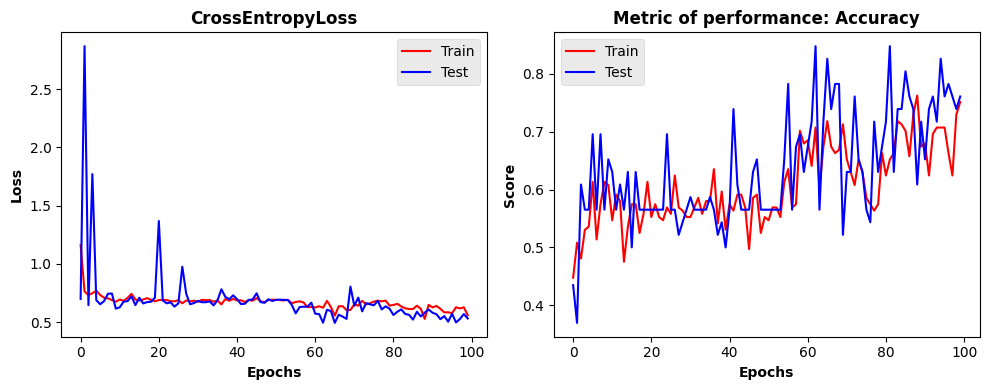

In [66]:
plot_loss_metric_curve(MODEL_RESULTS)

In [69]:
# We load the best model.
path_checkpoint = "/content/best_model.pt"
checkpoint = torch.load(path_checkpoint)

In [70]:
# We visualize the time when we obtained the least loss.
epoch = checkpoint["epoch"] + 1
loss = checkpoint["loss"]
print(f"Epoch: {epoch}")
print(f"Loss: {loss}")

Epoch: 66
Loss: 0.49384342270846265


In [71]:
model_efficientnet.load_state_dict(checkpoint["state_dict"])

model_efficientnet.eval()

with torch.inference_mode():
  y_pred_train_logits = model_efficientnet(X_train_torch.to(device))
  y_pred_test_logits = model_efficientnet(X_test_torch.to(device))

In [72]:
# Predictions Training
y_pred_train_probs = torch.sigmoid(y_pred_train_logits)
y_pred_train_class = torch.round(y_pred_train_probs).squeeze(dim = 1)
y_pred_train = y_pred_train_class.cpu().numpy()

# Predictions Test
y_pred_test_probs = torch.sigmoid(y_pred_test_logits)
y_pred_test_class = torch.round(y_pred_test_probs).squeeze(dim = 1)
y_pred_test = y_pred_test_class.cpu().numpy()

In [73]:
# We create the confusion matrix for the training and test set.
y_train_np = y_train_array.astype(int).squeeze()
y_pred_train_np = y_pred_train.astype(int)

y_test_np = y_test_array.astype(int).squeeze()
y_pred_test_np = y_pred_test.astype(int)

cf_mx_train = confusion_matrix(y_train_np, y_pred_train_np)
cf_mx_test = confusion_matrix(y_test_np, y_pred_test_np)

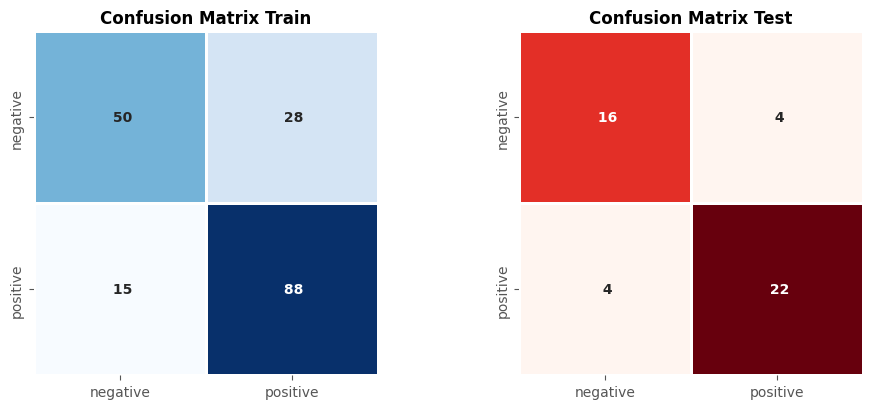

In [74]:
# Confusion Matrix Plot
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4.2))
ax = ax.flat
sns.heatmap(cf_mx_train,
            cmap = 'Blues',
            annot = True,
            fmt = ' ',
            annot_kws = {"fontsize":10,
                         "fontweight":"bold"},
            linewidths = 1,
            linecolor = "white",
            cbar = False,
            square = True,
            xticklabels = ["negative","positive"],
            yticklabels = ["negative","positive"],
            ax = ax[0])
ax[0].set_title('Confusion Matrix Train', fontsize = 12, fontweight = 'bold', color = 'black')
sns.heatmap(cf_mx_test,
            cmap = 'Reds',
            annot = True,
            fmt = ' ',
            annot_kws = {"fontsize":10,
                         "fontweight":"bold"},
            linewidths = 1,
            linecolor = "white",
            cbar = False,
            square = True,
            xticklabels = ["negative","positive"],
            yticklabels = ["negative","positive"],
            ax = ax[1])
ax[1].set_title('Confusion Matrix Test', fontsize = 12, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

In [75]:
# We create a dictionary to do a reverse mapping to the labels for both the training and test set.
id2label = {0: 'negative', 1: 'positive'}

In [76]:
# We convert the original labels and predictions from number to string by applying a mapping.
y_pred_train_id2label = np.array(pd.Series(y_pred_train_np).map(id2label))

y_train_np = np.array(y_train)

y_pred_test_id2label = np.array(pd.Series(y_pred_test_np).map(id2label))

y_test_np = np.array(y_test)

In [77]:
print("=="*30)
print(" " * 13, "Classification Report Train")
print("=="*30)
print(classification_report(y_train_np, y_pred_train_id2label))

print("=="*30)
print(" " * 13, "Classification Report Test")
print("=="*30)
print(classification_report(y_test_np, y_pred_test_id2label))

              Classification Report Train
              precision    recall  f1-score   support

    negative       0.77      0.64      0.70        78
    positive       0.76      0.85      0.80       103

    accuracy                           0.76       181
   macro avg       0.76      0.75      0.75       181
weighted avg       0.76      0.76      0.76       181

              Classification Report Test
              precision    recall  f1-score   support

    negative       0.80      0.80      0.80        20
    positive       0.85      0.85      0.85        26

    accuracy                           0.83        46
   macro avg       0.82      0.82      0.82        46
weighted avg       0.83      0.83      0.83        46

